In [1]:
import os
os.chdir('..')
print(f'Current working directory is {os.getcwd()}')

Current working directory is C:\Users\billy\Documents\NSS_projects\open-secrets-skittles


In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
#from data.Skittles_collection import state_code_df, get_all_districts

In [3]:
States_df = pd.read_csv('data/States_clean_df.csv')

In [4]:
States_df

,State,District,FirstLastP,Party,Raised,Spent,Difference,Outcome,Winner,CRPICO
0,Alabama,1,Jerry Carl (R),R,1971321.50,1859348.91,111972.59,W,1,O
1,Alabama,1,James Averhart (D),D,80094.95,78973.24,1121.71,L,0,O
2,Alabama,2,Barry Moore (R),R,650806.75,669367.70,-18560.95,W,1,O
3,Alabama,2,Phyllis Harvey-Hall (D),D,56049.68,55988.07,61.61,L,0,O
4,Alabama,3,Mike D Rogers (R),R,1193111.43,1218563.76,-25452.33,W,1,I
...,...,...,...,...,...,...,...,...,...,...
846,Wisconsin,7,Tricia Zunker (D),D,1261957.30,1232690.26,29267.04,L,0,C
847,Wisconsin,8,Mike Gallagher (R),R,3202904.74,2841800.71,361104.03,W,1,I
848,Wisconsin,8,Amanda Stuck (D),D,416978.45,399915.94,17062.51,L,0,C
849,Wyoming,1,Liz Cheney (R),R,3003883.34,3060166.78,-56283.44,W,1,I


## Part 3: Statistical Modeling
Fit a logistic regression model to see if the amount spent has a statistically significant impact on the probability of winning an election.
Feel free to brainstorm ways to set up your model, but a suggestion to get started would be to calculate, for each candidate, the percentage of to total amount spent in their racby district e that was spent by them and use this as your predictor variable of interest. Hint: you may find the transform method (https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.transform.html) in combination with groupby useful to find the total spending by race.
Don't forget to include the incumbent variable in your model.
After fitting your model, interpret the meaning of the coefficients you get.

In [6]:
States_df['Percentage_Spent'] = States_df.groupby(['State', 'District'])['Spent'].transform(lambda x: x / x.sum() * 100)

In [10]:
States_df.head(5)

,State,District,FirstLastP,Party,Raised,Spent,Difference,Outcome,Winner,CRPICO,Percentage_Spent,challenged_race,Is_Incumbent
0,Alabama,1,Jerry Carl (R),R,1971321.50,1859348.91,111972.59,W,1,O,95.925691,NaN,0
1,Alabama,1,James Averhart (D),D,80094.95,78973.24,1121.71,L,0,O,4.074309,NaN,0
2,Alabama,2,Barry Moore (R),R,650806.75,669367.70,-18560.95,W,1,O,92.281295,NaN,0
3,Alabama,2,Phyllis Harvey-Hall (D),D,56049.68,55988.07,61.61,L,0,O,7.718705,NaN,0
4,Alabama,3,Mike D Rogers (R),R,1193111.43,1218563.76,-25452.33,W,1,I,96.747125,I,1


In [12]:
states_winner_logreg = smf.logit("Winner ~ Percentage_Spent",data = States_df).fit() # how does the percentage spent on a race influence the likelihood of winning the race?

Optimization terminated successfully.
         Current function value: 0.239538
         Iterations 8


In [13]:
states_winner_logreg.params
# because the second coefficient is positive in this case, 
# we can say that by increasing spending for a race
# the probability of winning increases.

Intercept          -4.417373
Percentage_Spent    0.088130
dtype: float64

In [14]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

In [15]:
percentage_spent = 65 # this is a percentage of total amount spent for a district
logit_p = states_winner_logreg.params['Intercept'] + states_winner_logreg.params['Percentage_Spent']*percentage_spent

In [16]:
print(f'Estimated Probability of Winning: {logistic(logit_p)} based on {percentage_spent}% of total spending for a districts race.')

Estimated Probability of Winning: 0.7876943480632752 based on 65% of total spending for a districts race.


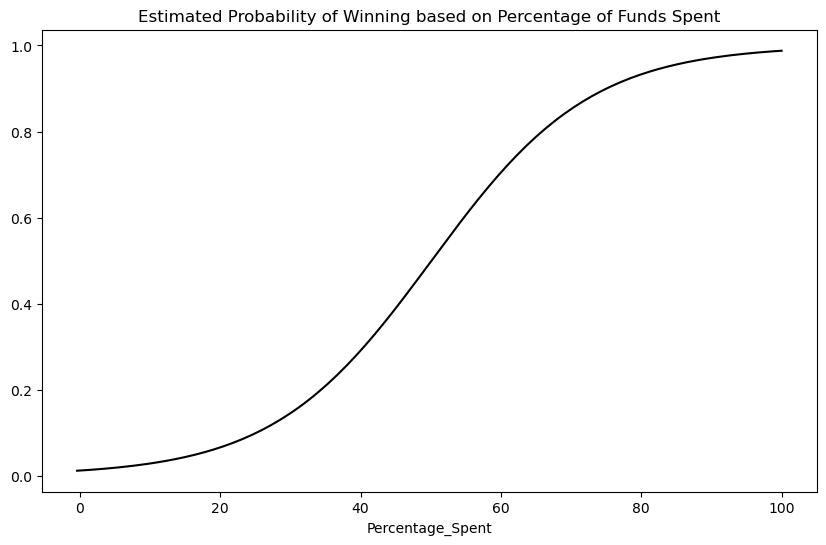

In [17]:
fit_df = pd.DataFrame({
    'Percentage_Spent': np.linspace(start = States_df['Percentage_Spent'].min(),
                            stop = States_df['Percentage_Spent'].max(),
                            num = 150)
})

fit_df['fit'] = states_winner_logreg.predict(fit_df) # this does logistic function for you and calculating probability for you for the sample you feed it.
# fg_dist_logreg(model)
# fit_df(data - in this case a sample)

fit_df.plot(x = 'Percentage_Spent',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of Winning based on Percentage of Funds Spent');

In [18]:
# diagnostic plots to verify our findings

In [19]:
# chopping up every percentage of total spent into groups. 
# first column : the second index represents a group that spent between (1.07%, 5.371%] of total spending. 
# second column : the average of percentage spent for that group is %3.058945
# third column : estimated probability of winning based on percentage spent of the total amount. (taking an average of occurence of 1 in the Winner series which represents winning in this case)
# these are all the observed probabilites. 
spent_summary = (
    States_df
    .assign(group = pd.qcut(States_df['Percentage_Spent'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Percentage_Spent', 'Winner']]
    .mean()
    .reset_index()
    .rename(columns = {'Winner': 'eprob'})
)
spent_summary

,group,Percentage_Spent,eprob
0,"(-0.393, 1.07]",0.289626,0.000000
1,"(1.07, 5.371]",3.058945,0.000000
2,"(5.371, 17.883]",10.385744,0.011765
3,"(17.883, 34.008]",26.338581,0.176471
4,"(34.008, 51.974]",43.157200,0.435294
5,"(51.974, 68.312]",60.258937,0.623529
6,"(68.312, 86.617]",77.394997,0.870588
7,"(86.617, 96.105]",92.505084,0.988235
8,"(96.105, 100.0]",99.186092,0.994118


In [20]:
# this is the model's estimation based off the data.

spent_summary['fit_prob'] = states_winner_logreg.predict(spent_summary[['Percentage_Spent']])
spent_summary
# for index 8, the model estimates that candidates who spent between (96.105, 100.0] 
# of total amount have a 0.986925 probability of winning. 

,group,Percentage_Spent,eprob,fit_prob
0,"(-0.393, 1.07]",0.289626,0.000000,0.012226
1,"(1.07, 5.371]",3.058945,0.000000,0.015554
2,"(5.371, 17.883]",10.385744,0.011765,0.029253
3,"(17.883, 34.008]",26.338581,0.176471,0.109471
4,"(34.008, 51.974]",43.157200,0.435294,0.351164
5,"(51.974, 68.312]",60.258937,0.623529,0.709561
6,"(68.312, 86.617]",77.394997,0.870588,0.917090
7,"(86.617, 96.105]",92.505084,0.988235,0.976686
8,"(96.105, 100.0]",99.186092,0.994118,0.986925


**Diagnostic Plot 1**: The observed probabilities and prediction model probabilites

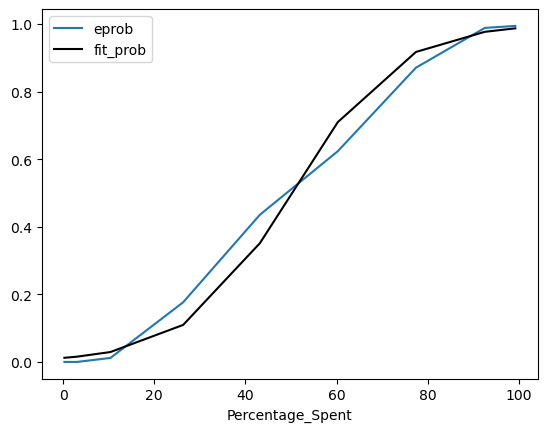

In [22]:
ax = spent_summary.plot(x = 'Percentage_Spent', y = 'eprob')
spent_summary.plot(x = 'Percentage_Spent', y = 'fit_prob',
                color = 'black',
                ax = ax);
# we plotted the probability of winning based on observed probablities versus the models predictions
#

**Diagnostic plot 2**: Plotting logit function to observe a linear plot. *This is not necessary to do,*

In [24]:
# spent_summary['elogit'] = np.log(spent_summary['eprob'] / (1 - spent_summary['eprob']))
# spent_summary['fit_logit'] = np.log(spent_summary['fit_prob'] / (1 - spent_summary['fit_prob']))
# spent_summary

C:\Users\billy\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,group,Percentage_Spent,eprob,fit_prob,elogit,fit_logit
0,"(-0.393, 1.07]",0.289626,0.000000,0.012226,-inf,-4.391848
1,"(1.07, 5.371]",3.058945,0.000000,0.015554,-inf,-4.147788
2,"(5.371, 17.883]",10.385744,0.011765,0.029253,-4.430817,-3.502077
3,"(17.883, 34.008]",26.338581,0.176471,0.109471,-1.540445,-2.096151
4,"(34.008, 51.974]",43.157200,0.435294,0.351164,-0.260283,-0.613925
5,"(51.974, 68.312]",60.258937,0.623529,0.709561,0.504556,0.893253
6,"(68.312, 86.617]",77.394997,0.870588,0.917090,1.906170,2.403455
7,"(86.617, 96.105]",92.505084,0.988235,0.976686,4.430817,3.735109
8,"(96.105, 100.0]",99.186092,0.994118,0.986925,5.129899,4.323907


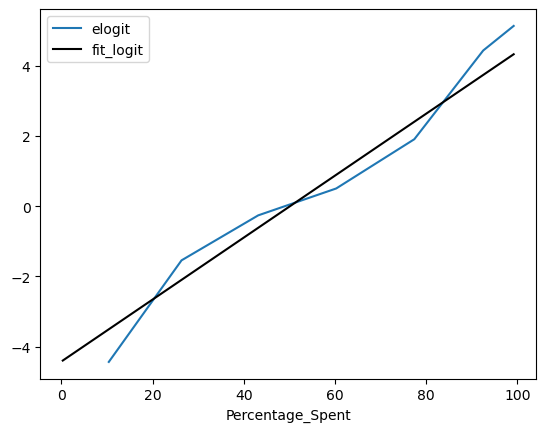

In [25]:
ax = spent_summary.plot(x = 'Percentage_Spent', y = 'elogit')
spent_summary.plot(x = 'Percentage_Spent', y = 'fit_logit',
                color = 'black',
                ax = ax);

In [26]:
States_df

,State,District,FirstLastP,Party,Raised,Spent,Difference,Outcome,Winner,CRPICO,Percentage_Spent,challenged_race,Is_Incumbent
0,Alabama,1,Jerry Carl (R),R,1971321.50,1859348.91,111972.59,W,1,O,95.925691,NaN,0
1,Alabama,1,James Averhart (D),D,80094.95,78973.24,1121.71,L,0,O,4.074309,NaN,0
2,Alabama,2,Barry Moore (R),R,650806.75,669367.70,-18560.95,W,1,O,92.281295,NaN,0
3,Alabama,2,Phyllis Harvey-Hall (D),D,56049.68,55988.07,61.61,L,0,O,7.718705,NaN,0
4,Alabama,3,Mike D Rogers (R),R,1193111.43,1218563.76,-25452.33,W,1,I,96.747125,I,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,Wisconsin,7,Tricia Zunker (D),D,1261957.30,1232690.26,29267.04,L,0,C,32.894284,C,0
847,Wisconsin,8,Mike Gallagher (R),R,3202904.74,2841800.71,361104.03,W,1,I,87.663452,I,1
848,Wisconsin,8,Amanda Stuck (D),D,416978.45,399915.94,17062.51,L,0,C,12.336548,C,0
849,Wyoming,1,Liz Cheney (R),R,3003883.34,3060166.78,-56283.44,W,1,I,95.857828,I,1


In [81]:
States_df['Is_Incumbent'] = States_df['challenged_race'].apply(lambda x: 1 if x == 'I' else 0)

In [184]:
States_df

,State,District,FirstLastP,Party,Raised,Spent,Difference,Outcome,Winner,CRPICO,Percentage_Spent,challenged_race,Is_Incumbent
0,Alabama,1,Jerry Carl (R),R,1971321.50,1859348.91,111972.59,W,1,O,95.925691,NaN,0
1,Alabama,1,James Averhart (D),D,80094.95,78973.24,1121.71,L,0,O,4.074309,NaN,0
2,Alabama,2,Barry Moore (R),R,650806.75,669367.70,-18560.95,W,1,O,92.281295,NaN,0
3,Alabama,2,Phyllis Harvey-Hall (D),D,56049.68,55988.07,61.61,L,0,O,7.718705,NaN,0
4,Alabama,3,Mike D Rogers (R),R,1193111.43,1218563.76,-25452.33,W,1,I,96.747125,I,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
846,Wisconsin,7,Tricia Zunker (D),D,1261957.30,1232690.26,29267.04,L,0,C,32.894284,C,0
847,Wisconsin,8,Mike Gallagher (R),R,3202904.74,2841800.71,361104.03,W,1,I,87.663452,I,1
848,Wisconsin,8,Amanda Stuck (D),D,416978.45,399915.94,17062.51,L,0,C,12.336548,C,0
849,Wyoming,1,Liz Cheney (R),R,3003883.34,3060166.78,-56283.44,W,1,I,95.857828,I,1


In [83]:
States_df = States_df.assign(challenged_race = incumbent_challenger)

In [85]:
incumbent_challenger = States_df.loc[(States_df['CRPICO'] != 'O'), ['CRPICO']]

In [164]:
states_winner_isIncumbent_logreg = smf.logit("Winner ~ Percentage_Spent + Is_Incumbent", data = States_df).fit()

Optimization terminated successfully.
         Current function value: 0.179260
         Iterations 8


In [166]:
states_winner_isIncumbent_logreg.params

Intercept          -4.316479
Percentage_Spent    0.062122
Is_Incumbent        3.235419
dtype: float64

In [168]:
states_winner_isIncumbent_logreg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Winner   No. Observations:                  851
Model:                          Logit   Df Residuals:                      848
Method:                           MLE   Df Model:                            2
Date:                Fri, 15 Nov 2024   Pseudo R-squ.:                  0.7413
Time:                        23:46:25   Log-Likelihood:                -152.55
converged:                       True   LL-Null:                       -589.74
Covariance Type:            nonrobust   LLR p-value:                1.357e-190
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -4.3165      0.341    -12.663      0.000      -4.985      -3.648
Percentage_Spent     0.0621      0.006     10.311      0.000       0.050       0.074
Is_Incumbent         3.2354      0.356      9.078      0.000       2.537       3.934
====================================================================================
"""

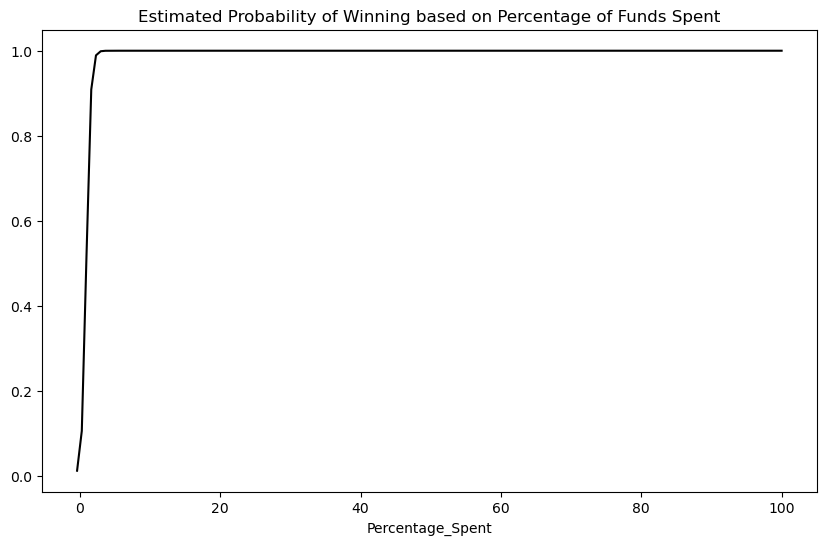

In [182]:
fit_df = pd.DataFrame({
    'Percentage_Spent': np.linspace(start = States_df['Percentage_Spent'].min(),
                            stop = States_df['Percentage_Spent'].max(),
                            num = 150),
    'Is_Incumbent': np.linspace(start = States_df['Is_Incumbent'].min(),
                            stop = States_df['Percentage_Spent'].max(),
                            num = 150)
})

fit_df['fit'] = states_winner__isIncumbent_logreg.predict(fit_df) # this does logistic function for you and calculating probability for you for the sample you feed it.
# fg_dist_logreg(model)
# fit_df(data - in this case a sample)

fit_df.plot(x = 'Percentage_Spent',
             y = 'fit',
             legend = False,
             figsize = (10,6),
             color = 'black',
            title = 'Estimated Probability of Winning based on Percentage of Funds Spent');

In [121]:
spent_summary = (
    States_df
    .assign(group = pd.qcut(States_df['Percentage_Spent'], 
                            q = 10, 
                            duplicates = 'drop'))
    .groupby('group', observed = False)
    [['Percentage_Spent', 'Is_Incumbent', 'Winner']]
    .mean()
    .reset_index()
    .rename(columns = {'Winner': 'eprob'})
)
spent_summary
# the probability of winning increases with the increase in spending as a percentage of total. 

,group,Percentage_Spent,Is_Incumbent,eprob
0,"(-0.393, 1.07]",0.289626,0.000000,0.000000
1,"(1.07, 5.371]",3.058945,0.000000,0.000000
2,"(5.371, 17.883]",10.385744,0.011765,0.011765
3,"(17.883, 34.008]",26.338581,0.070588,0.176471
4,"(34.008, 51.974]",43.157200,0.270588,0.435294
5,"(51.974, 68.312]",60.258937,0.647059,0.623529
6,"(68.312, 86.617]",77.394997,0.870588,0.870588
7,"(86.617, 96.105]",92.505084,0.823529,0.988235
8,"(96.105, 100.0]",99.186092,0.923529,0.994118


In [148]:
# reduced_model = smf.logit('Winner ~ 1',
#                         data = States_df).fit()
# full_model = smf.logit('Winner ~ Percentage_Spent + Is_Incumbent',
#                       data = States_df).fit()


Optimization terminated successfully.
         Current function value: 0.692992
         Iterations 3
Optimization terminated successfully.
         Current function value: 0.179260
         Iterations 8
